In [ ]:
# Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import zipfile
from keras import backend as K
from keras.models import Model
from keras.engine.topology import Layer
from keras.layers import Input
from keras.layers.core import Dense, Lambda, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv2D
from keras.layers.merge import Concatenate, Add
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, LambdaCallback, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD
import os

In [ ]:
# Import dataset from Drive
with zipfile.ZipFile("drive/My Drive/majVoting-two.zip", "r") as zip:
  zip.extractall()

In [ ]:
# Move from majVoting to the test folder
os.mkdir('test')
os.mkdir('test/Yes')
os.mkdir('test/No')

In [ ]:
# Move files in the test folder
# Separate the tweets of week 44 as te testing dataset
twts = pd.read_csv('drive/MyDrive/alltwts.csv')
w44 = twts[twts.week == 'w44']

In [ ]:
start = 'majVoting-two/'
dest = 'test/'
classes = ['Yes', 'No']
ext = '.jpg'

for i in w44['id_str'].values:
    for c in classes:
      print(start+c+'/'+str(i)+ext)
      print(os.path.isfile(start+c+'/'+str(i)+ext))
      if os.path.isfile(start+c+'/'+str(i)+ext):
        os.rename(start+c+'/'+i+ext, dest+c+'/'+str(i)+ext)

In [ ]:
# Dataset Generation from Directory
bSize = 50
seed = 12345
eps = 100

rows = 75
cols = 75
channels = 3

path = "majVoting-two"

# Define the generator
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 30,
    rescale=1./ 255,
    shear_range= 0.15,
    zoom_range= 0.15,
    horizontal_flip=True,
    validation_split = 0.2
)

train = datagen.flow_from_directory(
    directory = path,
    target_size = (rows, cols),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = bSize,
    subset = 'training'
)

val = datagen.flow_from_directory(
    directory = path,
    target_size = (rows, cols),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = bSize,
    subset = 'validation'
)

Found 5402 images belonging to 2 classes.
Found 1350 images belonging to 2 classes.


In [ ]:
label_map = (val.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
label_map

{0: 'No', 1: 'Yes'}

In [ ]:
# Classifier Definition
def transfer_schedule(epoch):
        if epoch < 30:
            return 0.3
        if epoch < 60:
            return 0.4
        if epoch < 90:
            return 0.5
        if epoch < 120:
            return 0.2
        if epoch < 150:
            return 0.1
        if epoch < 180:
            return 0.05
        if epoch < 210:
            return 0.025
        if epoch < 240:
            return 0.0125
        if epoch < 270:
            return 0.00625
        return 0.003125

class AttentionVGG:

    def VGGBlock(self, x, regularizer=None, batchnorm=False):
        if batchnorm:
            x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv1')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv2')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv3')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv4')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv5')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv6')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv7')(x)
            x = BatchNormalization()(x)
            local1 = Activation('relu')(x)  # batch*x*y*channel
            x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

            x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv8')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv9')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv10')(x)
            x = BatchNormalization()(x)
            local2 = Activation('relu')(x)
            x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(local2)

            x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv11')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv12')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv13')(x)
            x = BatchNormalization()(x)
            local3 = Activation('relu')(x)
            x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(local3)

            x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv14')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)
            x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizer, name='conv15')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)
            x = Flatten(name='pregflatten')(x)
            g = Dense(512, activation='relu', kernel_regularizer=regularizer, name='globalg')(x)  # batch*512
            return (g, local1, local2, local3)
        else:
            x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, name='conv1')(x)
            x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, name='conv2')(x)

            x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, name='conv3')(x)
            x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, name='conv4')(x)

            x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, name='conv5')(x)
            x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, name='conv6')(x)
            local1 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer,
                            name='conv7')(x)  # batch*x*y*channel
            x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(local1)

            x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, name='conv8')(x)
            x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, name='conv9')(x)
            local2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer,
                            name='conv10')(x)
            x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(local2)

            x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, name='conv11')(x)
            x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, name='conv12')(x)
            local3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer,
                            name='conv13')(x)
            x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(local3)

            x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, name='conv14')(x)
            x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)
            x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer, name='conv15')(x)
            x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)
            x = Flatten(name='pregflatten')(x)
            g = Dense(512, activation='relu', kernel_regularizer=regularizer, name='globalg')(x)  # batch*512
            return (g, local1, local2, local3)

    def __init__(self, att='att3', gmode='concat', compatibilityfunction='pc', datasetname="cifar100", height=rows,
                 width=cols, channels= channels, outputclasses=10, batchnorm=True, batchnormalizeinput=True, weight_decay=0.005,
                 optimizer=SGD(lr=0.01, momentum=0.9, decay=0.00001), loss='categorical_crossentropy',
                 metrics=['accuracy']):
        inp = Input(shape=(height, width, channels))
        input = inp
        if batchnormalizeinput:
            input = BatchNormalization()(input)
        regularizer = keras.regularizers.l2(weight_decay)
        self.datasetname = datasetname
        self.outputclasses = outputclasses

        (g, local1, local2, local3) = self.VGGBlock(input, regularizer, batchnorm)

        l1 = Dense(512, kernel_regularizer=regularizer, name='l1connectordense')(local1)  # batch*x*y*512
        c1 = ParametrisedCompatibility(kernel_regularizer=regularizer, name='cpc1')([l1, g])  # batch*x*y
        if compatibilityfunction == 'dp':
            c1 = Lambda(lambda lam: K.squeeze(
                K.map_fn(lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype='float32'),
                3), name='cdp1')([l1, g])  # batch*x*y
        flatc1 = Flatten(name='flatc1')(c1)  # batch*xy
        a1 = Activation('softmax', name='softmax1')(flatc1)  # batch*xy
        reshaped1 = Reshape((-1, 512), name='reshape1')(l1)  # batch*xy*512.
        g1 = Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), name='g1')(
            [a1, reshaped1])  # batch*512.

        l2 = local2
        c2 = ParametrisedCompatibility(kernel_regularizer=regularizer, name='cpc2')([l2, g])
        if compatibilityfunction == 'dp':
            c2 = Lambda(lambda lam: K.squeeze(
                K.map_fn(lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype='float32'),
                3), name='cdp2')([l2, g])
        flatc2 = Flatten(name='flatc2')(c2)
        a2 = Activation('softmax', name='softmax2')(flatc2)
        reshaped2 = Reshape((-1, 512), name='reshape2')(l2)
        g2 = Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), name='g2')([a2, reshaped2])

        l3 = local3
        c3 = ParametrisedCompatibility(kernel_regularizer=regularizer, name='cpc3')([l3, g])
        if compatibilityfunction == 'dp':
            c3 = Lambda(lambda lam: K.squeeze(
                K.map_fn(lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype='float32'),
                3), name='cdp3')([l3, g])
        flatc3 = Flatten(name='flatc3')(c3)
        a3 = Activation('softmax', name='softmax3')(flatc3)
        reshaped3 = Reshape((-1, 512), name='reshape3')(l3)
        g3 = Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), name='g3')([a3, reshaped3])

        out = ''
        if gmode == 'concat':
            glist = [g3]
            if att == 'att2':
                glist.append(g2)
            if att == 'att3':
                glist.append(g2)
                glist.append(g1)
            predictedG = g3
            if att != 'att1' and att != 'att':
                predictedG = Concatenate(axis=1, name='ConcatG')(glist)
            x = Dense(outputclasses, kernel_regularizer=regularizer, name=str(outputclasses) + 'ConcatG')(predictedG)
            out = Activation("softmax", name='concatsoftmaxout')(x)
        else:
            gd3 = Dense(outputclasses, activation='softmax', name=str(outputclasses) + 'indepsoftmaxg3')(g3)
            if att == 'att' or att == 'att1':
                out = gd3
            elif att == 'att2':
                gd2 = Dense(outputclasses, activation='softmax', kernel_regularizer=regularizer,
                            name=str(outputclasses) + 'indepsoftmaxg2')(g2)
                out = Add(name='addg3g2')([gd3, gd2])
                out = Lambda(lambda lam: lam / 2, name='2average')(out)
            else:
                gd2 = Dense(outputclasses, activation='softmax', kernel_regularizer=regularizer,
                            name=str(outputclasses) + 'indepsoftmaxg2')(g2)
                gd1 = Dense(outputclasses, activation='softmax', kernel_regularizer=regularizer,
                            name=str(outputclasses) + 'indepsoftmaxg2')(g1)
                out = Add(name='addg3g2g1')([gd1, gd2, gd3])
                out = Lambda(lambda lam: lam / 3, name='3average')(out)

        model = Model(inputs=inp, outputs=out)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        name = ("(VGG-" + att + ")-" + gmode + "-" + compatibilityfunction).replace('att)', 'att1)')
        print("Generated " + name)
        self.name = name
        self.model = model

    def StandardFit(self, datasetname=None, train_data = None, transfer=False, initial_lr=0.01, min_delta=None,
                    patience=20, val_data=None, lrplateaufactor=None, lrplateaupatience=4):
        if datasetname == None:
            datasetname = self.datasetname
        if os.path.isfile("weights/" + self.name + "-" + datasetname + " early.hdf5"):
            print("Found early-stopped weights for " + self.name + "-" + datasetname)
            return
        #scheduler = LearningRateScaler(25, 0.5, initial_lr)
        scheduler = LearningRateScheduler(transfer_schedule)
        startingepoch = 0
        pastepochs = list(map(int,
                              [x.replace(".hdf5", "").replace(self.name + "-" + datasetname, "").replace(" ", "") for x
                               in os.listdir("weights") if (self.name + "-" + datasetname in x) & ("early" not in x)]))
        if len(pastepochs):
            if max(pastepochs) == 300:
                print("Found completely trained weights for " + self.name + "-" + datasetname)
                return
            self.model.load_weights("weights/" + self.name + "-" + datasetname + " " + str(max(pastepochs)) + ".hdf5")
            startingepoch = max(pastepochs)
        elif transfer:
            if os.path.isfile("weights/" + self.name + "-" + datasetname + " early.hdf5"):
                self.model.load_weights("weights/" + self.name + "-" + datasetname + " early.hdf5", by_name=True)
            else:
                self.model.load_weights("weights/" + self.name + "-cifar100 300.hdf5", by_name=True)
            scheduler = LearningRateScheduler(transfer_schedule)
        tboardcb = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=3, write_graph=True, write_grads=False,
                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
                               embeddings_metadata=None)
        checkpoint = ModelCheckpoint("weights/" + self.name + "-" + datasetname + " {epoch}.hdf5",
                                     save_weights_only=True)
        epochprint = LambdaCallback(on_epoch_end=lambda epoch, logs: print("Passed epoch " + str(epoch)))
        callbackslist = [scheduler, checkpoint, epochprint, tboardcb]
        if val_data == None:
            self.model.fit(train_data, batch_size = bSize, epochs = eps, steps_per_epoch = 5400/bSize, callbacks=callbackslist, initial_epoch=startingepoch, shuffle=True)
        else:
            if min_delta != None:
                callbackslist.append(EarlyStopping(monitor='val_accuracy', min_delta=min_delta, patience=patience))
            if lrplateaufactor != None:
                callbackslist.append(
                    ReduceLROnPlateau(monitor='loss', factor=lrplateaufactor, patience=lrplateaupatience))
            self.model.fit(train_data, batch_size = bSize, epochs = eps, steps_per_epoch = 5400/bSize, callbacks=callbackslist, initial_epoch=startingepoch, shuffle=True, validation_data = val_data)
            self.model.save_weights("weights/" + self.name + "-" + datasetname + " early.hdf5")
        pastepochs = list(map(int,
                              [x.replace(".hdf5", "").replace(self.name + "-" + datasetname, "").replace(" ", "") for x
                               in os.listdir("weights") if (self.name + "-" + datasetname in x) & ("early" not in x)]))
        if max(pastepochs) > 290:
            for filenum in range(1, 297):  # delete most of the lower weight files
                try:
                    os.remove("weights/" + self.name + "-" + datasetname + " " + str(filenum) + ".hdf5")
                except OSError:
                    pass
        return self.model


class ParametrisedCompatibility(Layer):

    def __init__(self, kernel_regularizer=None, **kwargs):
        super(ParametrisedCompatibility, self).__init__(**kwargs)
        self.regularizer = kernel_regularizer

    def build(self, input_shape):
        self.u = self.add_weight(name='u', shape=(input_shape[0][3], 1), initializer='uniform',
                                 regularizer=self.regularizer, trainable=True)
        super(ParametrisedCompatibility, self).build(input_shape)

    def call(self, x):  # add l and g. Dot the sum with u.
        return K.dot(K.map_fn(lambda lam: (lam[0] + lam[1]), elems=(x), dtype='float32'), self.u)

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], input_shape[0][2])


class LearningRateScaler(Callback):

    def __init__(self, epochs, multiplier, initial_lr=None):
        self.multiplier = multiplier
        self.epochs = epochs
        self.initial_lr = initial_lr
        self.startingepoch = True

    def on_train_begin(self, logs=None):
        if self.initial_lr == None:
            self.initial_lr = K.get_value(self.model.optimizer.lr)
        print("Initial lr=" + str(self.initial_lr))

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        print("Current lr: " + str(K.get_value(self.model.optimizer.lr)))
        lr = self.initial_lr
        if (epoch > 0 and epoch % self.epochs == 0) or self.startingepoch:
            for i in range(0, epoch // self.epochs):
                lr = lr * self.multiplier
            K.set_value(self.model.optimizer.lr, lr)
            print("Updated learning rate to " + str(lr))
            self.startingepoch = False
        elif isinstance(self.epochs, list):
            if epoch > 0 and epoch in self.epochs.sort():
                for i in range(0, self.epochs.sort().index(epoch) + 1):
                    lr = lr * self.multiplier
                K.set_value(self.model.optimizer.lr, lr)
                print("Updated learning rate to " + str(lr))

    def on_epoch_end(self, epoch, logs=None):
        startingepoch = False

In [ ]:
os.mkdir("weights")

FileExistsError: ignored

In [ ]:
AttentionVGG = AttentionVGG(outputclasses=2).StandardFit("MaskNoMaskAttention",train_data = train, min_delta=0.01, patience=15, val_data=val)

Generated (VGG-att3)-concat-pc
Found early-stopped weights for (VGG-att3)-concat-pc-MaskNoMaskAttention


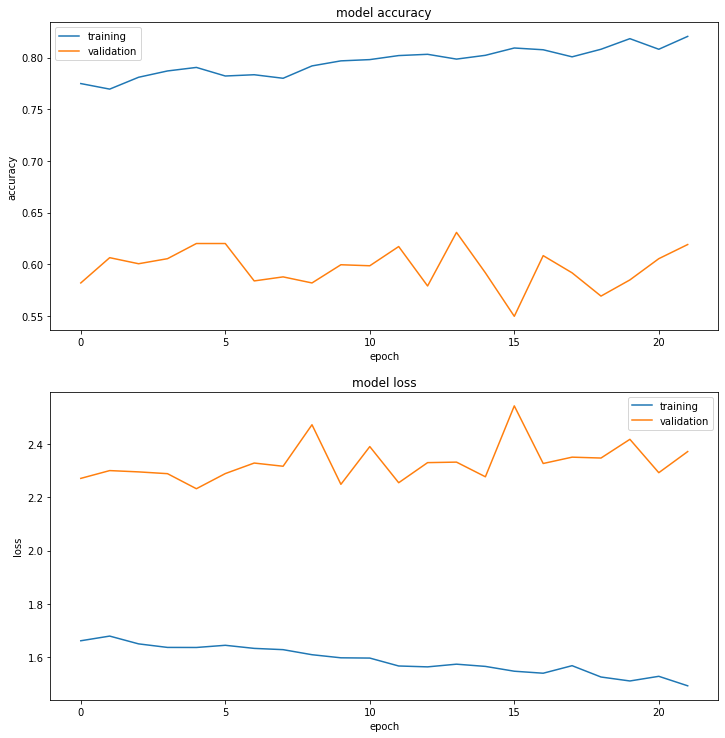

In [ ]:
import matplotlib.pyplot as plt

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(AttentionVGG.history.history['accuracy'], AttentionVGG.history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(AttentionVGG.history.history['loss'], AttentionVGG.history.history['val_loss'], 'loss', 212)